## Pre-request

In [60]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
train = pd.read_csv('./data/data.csv')

## 简单空值填充

In [8]:
# clean data
train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.mean())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables

# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24397.005804359607 logrmse: 0.11291591685262999


## XGB交叉验证

1.数据有限->发挥数据本来的效率

2.数据的训练集和评测集的矛盾

    如果用更多的数据去训练，那么就会有更少的数据来评测->失去了对于真实泛化能力的考量
    
    如果用更少的数据来训练，很大可能造成欠拟合，在评测集上表现就一定不好
    
解决方法：

1.将数据集拆成K份->(首先进行shuffle)

2.规定k-1份进行训练，剩下的1份进行评测，总共训练k次，轮流每个子数据集作为评测集

    数据集被分成K份，1......K
    
    第一次训练使用第1份数据集作为评测集，剩余的k-1份作为训练集
    
    第i次训练使用第i份数据集作为评测集，剩余的k-1份作为训练集
    
    做k次训练
    
3.k次训练之后，评测的分值=k次评测结果的平均

4.不同的模型会提供不同的子模型的合并方法，会将所有的k个子模型进行合并



In [23]:
params = {"objective":"reg:linear",
          'colsample_bytree': 0.7,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10}

train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train

y = train1['SalePrice']
X=pd.get_dummies(train1.drop(['Id', 'SalePrice'], axis=1)) # Convert categorical variable into dummy/indicator variables
matrix=xgb.DMatrix(data=X,label=y)

cv_results = xgb.cv(dtrain=matrix, params=params,
                    nfold = 5,  
                    num_boost_round=1, 
                    metrics = 'rmse',
                    as_pandas=True)

[17:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[17:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[17:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[17:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[17:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5


In [36]:
def getnullcount():
    x=train.isnull().sum()
    print(x[x>0])
    x[x>0].sort_values().plot.bar()

## EDA 与空值填充

In [100]:
train = pd.read_csv('./data/data.csv') # 训练集的读取
train1 = train

train['SqrtLotArea']=np.sqrt(train['LotArea'])
filter=train['LotFrontage'].isnull()
train.LotFrontage[filter]=0.6*train.SqrtLotArea[filter]

filter=train['MasVnrArea'].isnull()
train.MasVnrArea[filter]=0.0

filter=train['MasVnrType'].isnull()
train.MasVnrType[filter]='None'

filter=train['Electrical'].isnull()
train['Electrical'][filter]='SBrkr'

train['Alley']=train['Alley'].fillna('None')

basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
train[train.BsmtCond=='NA']
for col in basement_cols:
    if 'FinSF' not in col:
        train[col]=train[col].fillna('None')
#getnullcount()

train['FireplaceQu']=train['FireplaceQu'].fillna('None')
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']        
        
for col in garage_cols:
    if train[col].dtype==np.object:
        train[col]=train[col].fillna('None')
    else:
        train[col]=train[col].fillna(0)        


        
train.PoolQC=train.PoolQC.fillna('None')
train['Fence']=train['Fence'].fillna('None')
train['MiscFeature']=train['MiscFeature'].fillna('None')

train.to_csv('./data/train_1.csv')

## 数据集的准备

In [115]:
train = pd.read_csv('./data/train_1.csv')
train1 = train.drop(['Id','SalePrice'], axis=1)

X = pd.get_dummies(train1).reset_index(drop=True)
#X = X.drop('Unnamed: 0', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)



lm = LinearRegression()
p = lm.fit(X_train, y_train)
pred = p.predict(X_test)
print(np.sqrt(mean_squared_error(np.log(y_test), np.log(pred))))
print(np.sqrt(mean_squared_error(y_test,pred)))

def benchmark(model):
    pred=model.predict(X_test)
    logrmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
    return logrmse

print(benchmark(p))
print(benchmark(lm))

0.12618361140972376
24966.33741019887
0.12618361140972376
0.12618361140972376


## 数据预处理

In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lm_model=make_pipeline(RobustScaler(),LinearRegression())
lm_model.fit(X_train, y_train)
benchmark(lm_model)

0.12618361141005513

## 朴素的Ridge回归

In [124]:
from sklearn.linear_model import Ridge
ridge_model=Ridge(alpha=0.1)
ridge_model.fit(X_train,y_train)
benchmark(ridge_model)

0.12655652003733184

## 带有RobustScaler的回归

In [125]:
ridge_model_pipe=make_pipeline(RobustScaler(),Ridge(alpha=0.1))
ridge_model_pipe.fit(X_train,y_train)
benchmark(ridge_model_pipe)

0.12655937132758469

In [130]:
def benchmark1(model,testset,label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print('Neg Value')
    rmse=np.sqrt(mean_squared_error(label,pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(pred)))

    print('RMSE:',rmse)
    print('LRMSE:',lrmse)
    return lrmse

## 带有CV的回归

In [131]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV

kfolds=KFold(n_splits=10,shuffle=True,random_state=123)

r_alphas=[0.01,0.1,1,3,5,7,10,100]

ridge_model_cv=make_pipeline(RobustScaler(),RidgeCV(alphas=r_alphas,cv=kfolds))

ridge_model_cv.fit(X_train,y_train)

benchmark1(ridge_model_cv,X_test,y_test)
benchmark(ridge_model_cv)

RMSE: 26917.457956049773
LRMSE: 0.12438552197375949


0.12438552197375949

RMSE: 24966.403023810835
LRMSE: 0.12618468133670982
RMSE: 24966.53404954252
LRMSE: 0.1261867913113952
RMSE: 24966.664817098845
LRMSE: 0.12618886217756062
RMSE: 24966.795339861255
LRMSE: 0.12619089480008305
RMSE: 24966.925630911246
LRMSE: 0.12619289002273504
RMSE: 24972.8159840826
LRMSE: 0.12625505551667465
RMSE: 25007.89344047134
LRMSE: 0.12636426623739028
RMSE: 25070.76049543444
LRMSE: 0.12655937132758469
RMSE: 25331.38136595076
LRMSE: 0.12765621823283277
RMSE: 25785.94019059844
LRMSE: 0.13005002719016284
RMSE: 26033.309156661962
LRMSE: 0.13164569772057483
RMSE: 26021.284156113048
LRMSE: 0.13150831954283526
RMSE: 25912.00595901413
LRMSE: 0.13040651460413383
RMSE: 25851.247191696217
LRMSE: 0.12942505856751366
RMSE: 25837.650296852426
LRMSE: 0.12863398298618772
RMSE: 25894.21580406474
LRMSE: 0.12743758025937751
RMSE: 26148.05400132308
LRMSE: 0.12591254743971553
RMSE: 26299.322251440422
LRMSE: 0.12541103327969808
RMSE: 26454.855374654264
LRMSE: 0.12502851180211794
RMSE: 26610.9108937612


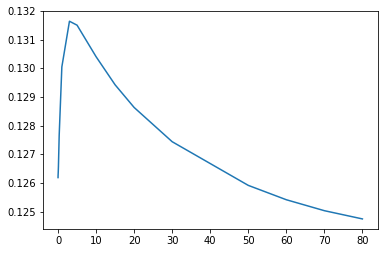

In [134]:
r_alphas=[.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

def ridge_train_test(alpha):
    m=make_pipeline(RobustScaler(),RidgeCV(alphas=[alpha],cv=kfolds))
    m.fit(X_train,y_train)
    return benchmark1(m,X_test,y_test)

scores=[]
for k in r_alphas:
    scores.append(ridge_train_test(k))
plt.plot(r_alphas,scores)